In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map 
import seaborn as sns
import pickle
from scipy import stats
import nibabel as nb
import nilearn
import cmasher as cmr

In [2]:
os.chdir('/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/5_analysis/decision_tree')

In [3]:
import nifti_subset_plotting_functions

run in py38 environment

## Load data

In [4]:
#load my local data
final_data_folder='../../4_derivatives/rabies_runs/local_data_final_runs'
DR_outputs_folder='../DR_analysis-to_extract_network_detectability/DR_outputs_variableWindows_niftis'
DR_niftis_somat = sorted(glob.glob(DR_outputs_folder + '/*prior5*.nii.gz'))
DR_niftis_dmn = sorted(glob.glob(DR_outputs_folder + '/*prior19*.nii.gz'))
DR_masks_somat = sorted(glob.glob(DR_outputs_folder + '/masks/*prior5*.nii.gz'))
DR_masks_dmn = sorted(glob.glob(DR_outputs_folder + '/masks/*prior19*.nii.gz'))
commonspace_template_file_local = os.path.abspath(final_data_folder + '/rabies_out_preprocess-v050/bold_datasink/commonspace_resampled_template/resampled_template.nii.gz')
commonspace_mask_file_local = os.path.abspath(final_data_folder + '/rabies_out_preprocess-v050/bold_datasink/commonspace_mask/_scan_info_subject_idPHG001.session1_split_name_sub-PHG001_ses-1_acq-RARE_T2w/_run_1/sub-PHG001_ses-1_task-rest_acq-EPI_run-1_bold_RAS_EPI_brain_mask.nii.gz')

# Functions

In [5]:
def plot_percent_overlap_in_subset(mask_files, commonspace_mask_file, variable_to_predict, characteristics_df, 
                                        columns, expressions, values, indices_high_iso):

    DR_nifti_dict = {}
    
    #iterate over all niftis and extract an array from each, store outputs in a dict
    for mask in mask_files:
        filename = os.path.basename(os.path.abspath(mask))
        sub_ses_ID = filename[filename.rfind('sub'):filename.rfind('_fit')]
        timewindow = filename[filename.rfind('time_')+5:filename.rfind('_mask.nii.gz')]
        ################################## extract which windows belong to this subset (according to df) ###################
        
        # separate df into train and test datasets
        X=characteristics_df.drop(columns=[variable_to_predict])
        Y=characteristics_df[variable_to_predict]
        X_train, _,_,_ = nifti_subset_plotting_functions.custom_stratified_train_test_split_with_group(X, Y, predetermined_test_groups=(1, 9, 12, 15, 25, 28, 31, 35, 42, 43), 
                                                                                        group = characteristics_df['session_ID'], 
                                                                                        random_state = 1)
        X_train = X_train.drop(indices_high_iso, errors = 'ignore')

        #find boolean arrays for whether a given point  satisfies each layer in the split
        indices_dict = {}
        for i in range(0, len(columns)):
            if expressions[i] == 'less than':
                indices_dict[i] = X_train[columns[i]] <= values[i]
            if expressions[i] == 'greater than':
                indices_dict[i] = X_train[columns[i]] > values[i]
            if expressions[i] == 'equal':
                indices_dict[i] = X_train[columns[i]] == values[i]

        # find subset of indices that satisfy all layers of the split
        if len(indices_dict.keys()) == 1:
            indices_subset = X_train.loc[indices_dict[0]].index
        elif len(indices_dict.keys()) == 2:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1]].index
        elif len(indices_dict.keys()) == 3:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2]].index
        elif len(indices_dict.keys()) == 4:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2] & indices_dict[3]].index
        else:
            print('more than 4 or fewer than 2 splits on at least one column')
        
        characteristics_df['In subset'] = [False]*len(characteristics_df)
        characteristics_df.loc[indices_subset.to_list(), 'In subset'] = True

        df_in_subset = characteristics_df.loc[characteristics_df['In subset'] == True]

        ############################ check if this file is in the subset ##########################
        if (sub_ses_ID in df_in_subset['epi_filename'].tolist()):
            df_in_subset_this_subject = df_in_subset.loc[df_in_subset['epi_filename'] == sub_ses_ID]
            if float(timewindow) in df_in_subset_this_subject['Start Time Realtime'].tolist():
                #if this subject and timewindow are in the subset, add the file to the dict

                _, _, nifti_masked_flat = nifti_subset_plotting_functions.preprocess_nifti(os.path.abspath(mask), commonspace_mask_file, False, 0)
                DR_nifti_dict[sub_ses_ID + '_' + timewindow] = nifti_masked_flat.reshape((16728,1)) #reshape from 1d (16728,) to 2d
    
    ################## once all the files in the subset have been located, concatenate them together #######3
    DR_nifti_array_in_subset = np.concatenate([DR_nifti_dict[x] for x in DR_nifti_dict], 1)
    percent_nifti_in_subset = np.sum(DR_nifti_array_in_subset, axis=1)*100/len(DR_nifti_dict.keys())
    return df_in_subset, DR_nifti_dict, percent_nifti_in_subset

In [6]:
def extract_DT_subset_of_epis_with_dict(epi_files, commonspace_mask_file, variable_to_predict, characteristics_df, 
                                        columns, expressions, values, indices_high_iso):

    DR_nifti_dict = {}
    
    #iterate over all niftis and extract an array from each, store outputs in a dict
    for epi in epi_files:
        filename = os.path.basename(os.path.abspath(epi))
        sub_ses_ID = filename[filename.rfind('sub'):filename.rfind('_fit')]
        timewindow = filename[filename.rfind('time_')+5:filename.rfind('.nii.gz')]
        ################################## extract which windows belong to this subset (according to df) ###################
        
        # separate df into train and test datasets
        X=characteristics_df.drop(columns=[variable_to_predict])
        Y=characteristics_df[variable_to_predict]
        X_train, _,_,_ = nifti_subset_plotting_functions.custom_stratified_train_test_split_with_group(X, Y, predetermined_test_groups=(1, 9, 12, 15, 25, 28, 31, 35, 42, 43), 
                                                                                        group = characteristics_df['session_ID'], 
                                                                                        random_state = 1)
        X_train = X_train.drop(indices_high_iso, errors = 'ignore')

        #find boolean arrays for whether a given point  satisfies each layer in the split
        indices_dict = {}
        for i in range(0, len(columns)):
            if expressions[i] == 'less than':
                indices_dict[i] = X_train[columns[i]] <= values[i]
            if expressions[i] == 'greater than':
                indices_dict[i] = X_train[columns[i]] > values[i]
            if expressions[i] == 'equal':
                indices_dict[i] = X_train[columns[i]] == values[i]

        # find subset of indices that satisfy all layers of the split
        if len(indices_dict.keys()) == 1:
            indices_subset = X_train.loc[indices_dict[0]].index
        elif len(indices_dict.keys()) == 2:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1]].index
        elif len(indices_dict.keys()) == 3:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2]].index
        elif len(indices_dict.keys()) == 4:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2] & indices_dict[3]].index
        else:
            print('more than 4 or fewer than 2 splits on at least one column')
        
        characteristics_df['In subset'] = [False]*len(characteristics_df)
        characteristics_df.loc[indices_subset.to_list(), 'In subset'] = True

        df_in_subset = characteristics_df.loc[characteristics_df['In subset'] == True]

        ############################ check if this file is in the subset ##########################
        if (sub_ses_ID in df_in_subset['epi_filename'].tolist()):
            df_in_subset_this_subject = df_in_subset.loc[df_in_subset['epi_filename'] == sub_ses_ID]
            if float(timewindow) in df_in_subset_this_subject['Start Time Realtime'].tolist():
                #if this subject and timewindow are in the subset, add the file to the dict

                _, _, nifti_masked_flat = nifti_subset_plotting_functions.preprocess_nifti(os.path.abspath(epi), commonspace_mask_file, False, 0.3)
                DR_nifti_dict[sub_ses_ID + '_' + timewindow] = nifti_masked_flat.reshape((16728,1)) #reshape from 1d (16728,) to 2d
    
    ################## once all the files in the subset have been located, concatenate them together and find mean #######3
    DR_nifti_array_in_subset = np.concatenate([DR_nifti_dict[x] for x in DR_nifti_dict], 1)
    mean_nifti_in_subset = np.mean(DR_nifti_array_in_subset, axis=1)
    return df_in_subset, DR_nifti_dict, mean_nifti_in_subset

In [7]:
def plot_percent_overlap_in_subset(mask_files, commonspace_mask_file, variable_to_predict, characteristics_df, 
                                        columns, expressions, values, indices_high_iso):

    DR_nifti_dict = {}
    
    #iterate over all niftis and extract an array from each, store outputs in a dict
    for mask in mask_files:
        filename = os.path.basename(os.path.abspath(mask))
        sub_ses_ID = filename[filename.rfind('sub'):filename.rfind('_fit')]
        timewindow = filename[filename.rfind('time_')+5:filename.rfind('_mask.nii.gz')]
        ################################## extract which windows belong to this subset (according to df) ###################
        
        # separate df into train and test datasets
        X=characteristics_df.drop(columns=[variable_to_predict])
        Y=characteristics_df[variable_to_predict]
        X_train, _,_,_ = nifti_subset_plotting_functions.custom_stratified_train_test_split_with_group(X, Y, predetermined_test_groups=(1, 9, 12, 15, 25, 28, 31, 35, 42, 43), 
                                                                                        group = characteristics_df['session_ID'], 
                                                                                        random_state = 1)
        X_train = X_train.drop(indices_high_iso, errors = 'ignore')

        #find boolean arrays for whether a given point  satisfies each layer in the split
        indices_dict = {}
        for i in range(0, len(columns)):
            if expressions[i] == 'less than':
                indices_dict[i] = X_train[columns[i]] <= values[i]
            if expressions[i] == 'greater than':
                indices_dict[i] = X_train[columns[i]] > values[i]
            if expressions[i] == 'equal':
                indices_dict[i] = X_train[columns[i]] == values[i]

        # find subset of indices that satisfy all layers of the split
        if len(indices_dict.keys()) == 1:
            indices_subset = X_train.loc[indices_dict[0]].index
        elif len(indices_dict.keys()) == 2:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1]].index
        elif len(indices_dict.keys()) == 3:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2]].index
        elif len(indices_dict.keys()) == 4:
            indices_subset = X_train.loc[indices_dict[0] & indices_dict[1] & indices_dict[2] & indices_dict[3]].index
        else:
            print('more than 4 or fewer than 2 splits on at least one column')
        
        characteristics_df['In subset'] = [False]*len(characteristics_df)
        characteristics_df.loc[indices_subset.to_list(), 'In subset'] = True

        df_in_subset = characteristics_df.loc[characteristics_df['In subset'] == True]

        ############################ check if this file is in the subset ##########################
        if (sub_ses_ID in df_in_subset['epi_filename'].tolist()):
            df_in_subset_this_subject = df_in_subset.loc[df_in_subset['epi_filename'] == sub_ses_ID]
            if float(timewindow) in df_in_subset_this_subject['Start Time Realtime'].tolist():
                #if this subject and timewindow are in the subset, add the file to the dict

                _, _, nifti_masked_flat = nifti_subset_plotting_functions.preprocess_nifti(os.path.abspath(mask), commonspace_mask_file, False, 0)
                DR_nifti_dict[sub_ses_ID + '_' + timewindow] = nifti_masked_flat.reshape((16728,1)) #reshape from 1d (16728,) to 2d
    
    ################## once all the files in the subset have been located, concatenate them together #######3
    DR_nifti_array_in_subset = np.concatenate([DR_nifti_dict[x] for x in DR_nifti_dict], 1)
    percent_nifti_in_subset = np.sum(DR_nifti_array_in_subset, axis=1)*100/len(DR_nifti_dict.keys())
    return df_in_subset, DR_nifti_dict, percent_nifti_in_subset

# CPP

In [8]:
#load csv
dr_phgy_df = pd.read_csv('../DR_analysis-to_extract_network_detectability/final_outputs/master_DR_and_phgy_variableWindow_sparse.csv')

# add a column that essentially binarizes network detectability into pass and fail
dr_phgy_df['Somatomotor or DMN network detected'] = (np.abs(dr_phgy_df['Average correlation to network'])>=0.45) 

#encode categorical variables as numbers (sklearn doesn't handle categories)
dr_phgy_df['strain'] = dr_phgy_df['strain'].map({'C57Bl/6':1, 'C3HeB/FeJ':2})
dr_phgy_df['sex'] = dr_phgy_df['sex'].map({'m':1, 'f':2})

indices_high_iso = dr_phgy_df[dr_phgy_df['Iso percent'] == 1.5].index

df = dr_phgy_df[['actual_ses_order', 'strain', 'sex', 
       'Time after isoflurane change',
       'Mean FD- mean in window', 'Max FD- mean in window',
        'Somatomotor or DMN network detected', 'Iso percent', 'dex_conc',
        'CPP0 frequency (sexstrain zscore)',
        'CPP1 frequency (sexstrain zscore)',
        'CPP2 frequency (sexstrain zscore)',
        'CPP3 frequency (sexstrain zscore)',
        'CPP4 frequency (sexstrain zscore)']]

#rename columns
df = df.rename(columns = {'actual_ses_order': 'session order (correlated to age)',
                            'Iso percent': 'isoflurane (%)',
                            'dex_conc': 'dexmedetomidine (mg/kg/h)',
                            'CPP0 frequency (sexstrain zscore)': 'state0 frequency (sexstrain zscore)',
                            'CPP1 frequency (sexstrain zscore)': 'state1 frequency (sexstrain zscore)',
                            'CPP2 frequency (sexstrain zscore)': 'state2 frequency (sexstrain zscore)',
                            'CPP3 frequency (sexstrain zscore)': 'state3 frequency (sexstrain zscore)',
                            'CPP4 frequency (sexstrain zscore)': 'state4 frequency (sexstrain zscore)'})
variable_to_predict = "Somatomotor or DMN network detected"


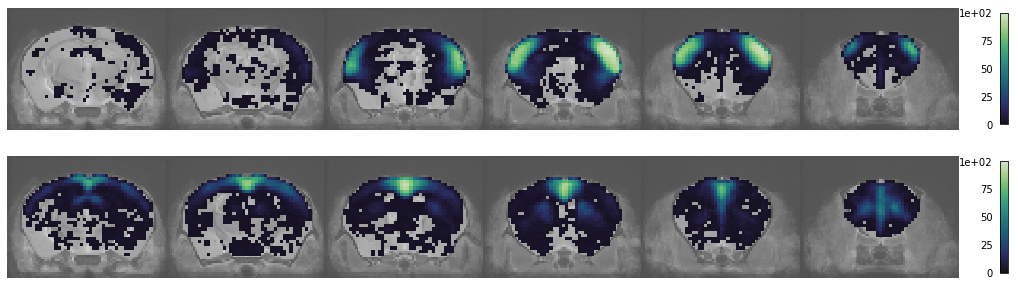

In [11]:
columns1 = ['Iso percent', 'CPP1 frequency (sexstrain zscore)']
expressions1 = ['less than', 'less than']
values1 = [0.75,  0.00851079]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_CPP-DR_percent_overlap_subset1_lowiso_rarestate1.svg', transparent = True)

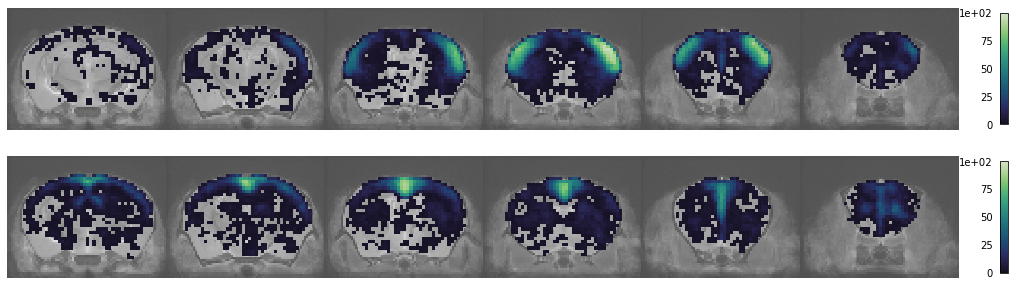

In [15]:
columns1 = ['Iso percent', 'CPP1 frequency (sexstrain zscore)']
expressions1 = ['less than', 'greater than']
values1 = [0.75,  0.00851079]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_CPP-DR_percent_overlap_subset2_lowiso_frequentstate1.svg', transparent = True)

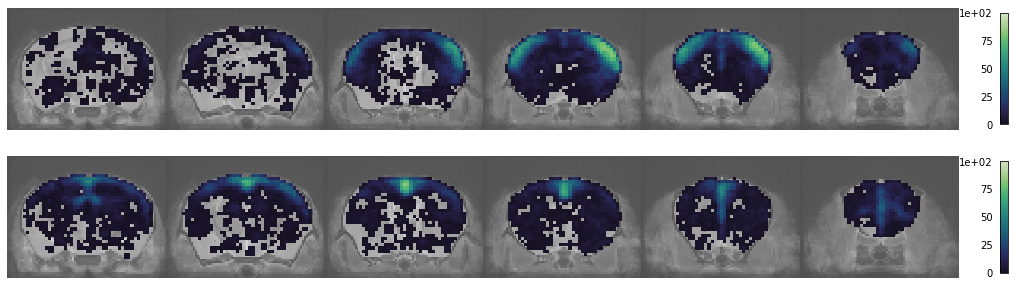

In [17]:
columns1 = ['Iso percent', 'CPP4 frequency (sexstrain zscore)']
expressions1 = ['greater than', 'less than']
values1 = [0.75,  0.26089057]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_CPP-DR_percent_overlap_subset3_highiso_rarestate4.svg', transparent = True)

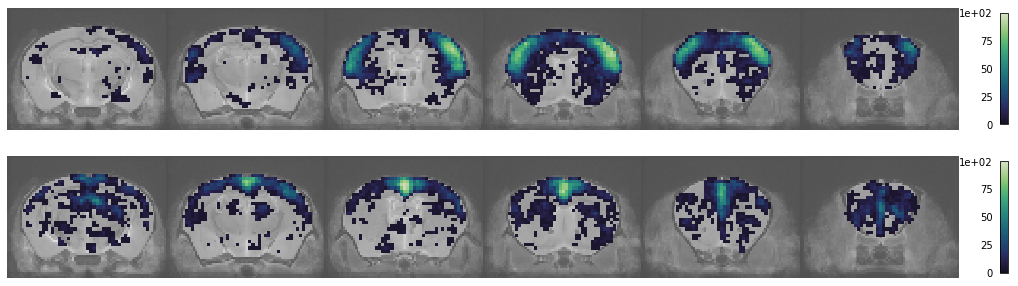

In [22]:
columns1 = ['Iso percent', 'CPP4 frequency (sexstrain zscore)']
expressions1 = ['greater than', 'greater than']
values1 = [0.75,  0.26089057]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            dr_phgy_df, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_CPP-DR_percent_overlap_subset4_highiso_frequentstate4.svg', transparent = True)

# PHGY version 

In [31]:
#load csv
dr_phgy_df = pd.read_csv('../DR_analysis-to_extract_network_detectability/final_outputs/master_DR_and_phgy_variableWindow_sparse.csv')

# add a column that essentially binarizes network detectability into pass and fail
dr_phgy_df['Somatomotor or DMN network detected'] = (np.abs(dr_phgy_df['Average correlation to network'])>=0.45) 

#properly encode the variables as numbers (sklearn doesn't handle categorical)
dr_phgy_df['strain'] = dr_phgy_df['strain'].map({'C57Bl/6':1, 'C3HeB/FeJ':2})
dr_phgy_df['sex'] = dr_phgy_df['sex'].map({'m':1, 'f':2})

indices_high_iso = dr_phgy_df[dr_phgy_df['Iso percent'] == 1.5].index

#select the independent and physiological variables from the full df.
df_for_subset_characteristics = dr_phgy_df[['epi_filename', 'Start Time Realtime', 'actual_ses_order', 'strain', 'sex', 'session_ID', 'age_days',
                                          'Time after isoflurane change',
                                            'Mean FD- mean in window', 'Max FD- mean in window',
                                            'RR-sexstrain_zscore- mean in window',
                                            'RRV-sexstrain_zscore- mean in window',
                                            'RV-sexstrain_zscore- mean in window',
                                            'HR-sexstrain_zscore- mean in window',
                                            'HRV- mean in window',
                                            'PVI- mean in window',
                                            'SpO2-sexstrain_zscore- mean in window',
                                          'Somatomotor or DMN network detected', 'Iso percent', 'dex_conc']]
df_for_subset_characteristics = df_for_subset_characteristics.rename(columns = {'actual_ses_order': 'session order (correlated to age)',
                            'Iso percent': 'isoflurane (%)', 'age_days': 'age (days)',
                            'dex_conc': 'dexmedetomidine (mg/kg/h)',
                            'RR-sexstrain_zscore- mean in window': 'RR (zscored by strain/sex)',
                        'RRV-sexstrain_zscore- mean in window': 'RRV (zscored by strain/sex)',
                        'RV-sexstrain_zscore- mean in window': 'RV (zscored by strain/sex)',
                        'HR-sexstrain_zscore- mean in window': 'HR (zscored by strain/sex)',
                        'HRV- mean in window': 'HRV', 
                        'PVI- mean in window': 'PVI ',
                        'SpO2-sexstrain_zscore- mean in window': 'SpO2 (zscored by strain/sex)',
                        'Mean FD- mean in window': 'Mean FD',
                          'Max FD- mean in window': 'Max FD'})
variable_to_predict = "Somatomotor or DMN network detected"

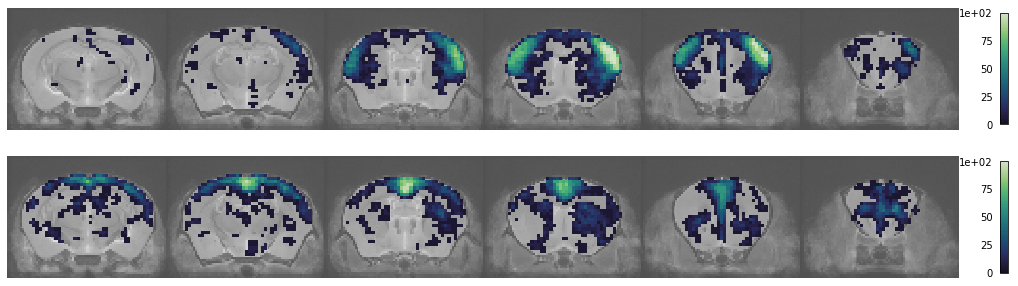

In [32]:
columns1 = ['isoflurane (%)', 'SpO2 (zscored by strain/sex)']
expressions1 = ['less than', 'less than']
values1 = [0.29, -0.65736049]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_phgy-DR_percent_overlap_subset1_verylowiso_lowspo2.svg', transparent = True)

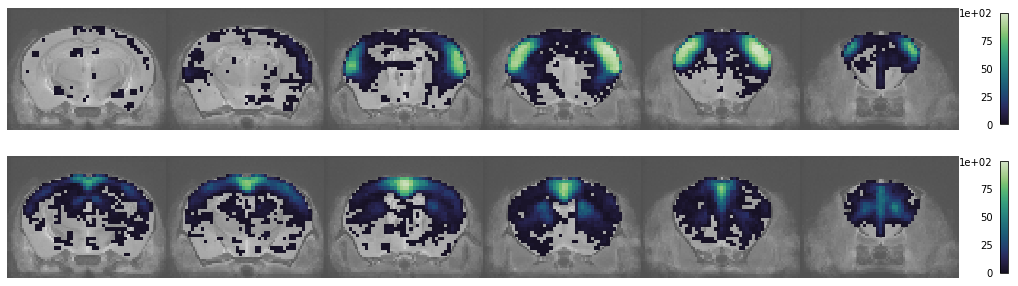

In [33]:
columns1 = ['isoflurane (%)', 'SpO2 (zscored by strain/sex)']
expressions1 = ['less than', 'greater than']
values1 = [0.29, -0.65736049]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_phgy-DR_percent_overlap_subset2_verylowiso_highspo2.svg', transparent = True)

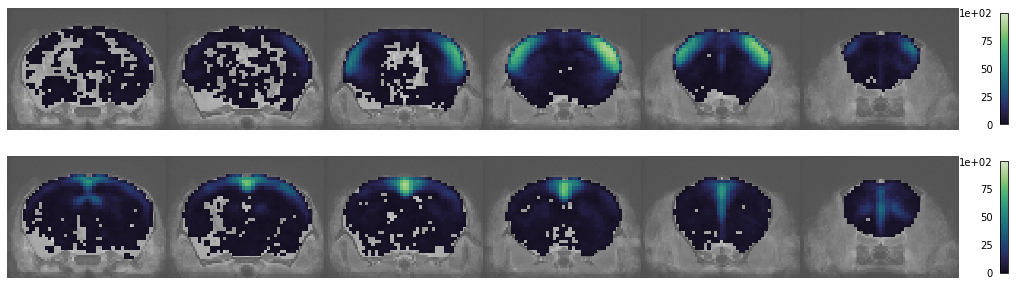

In [35]:
columns1 = ['isoflurane (%)']
expressions1 = ['greater than']
values1 = [0.29]
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2= plot_percent_overlap_in_subset(DR_masks_somat, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
df_in_layer2, DR_mask_dict_layer2, percent_im_layer2_dmn = plot_percent_overlap_in_subset(DR_masks_dmn, commonspace_mask_file_local,
                                                                                             "Somatomotor or DMN network detected",
                                                                                            df_for_subset_characteristics, columns1, expressions1, values1, 
                                                                                            indices_high_iso)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(18,5))
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[0],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
plot_stat_map(nifti_subset_plotting_functions.recover_3D(commonspace_mask_file_local, percent_im_layer2_dmn),
                                                        bg_img=commonspace_template_file_local, cut_coords=(0,1,2,3,4,5),
                                                        display_mode='y', colorbar=True, vmax = 100, axes = axs[1],
                                                        cmap = cmr.get_sub_cmap('cmr.seasons_s', 0.15, 0.95), black_bg = False, annotate = False)
fig.figure.savefig('./final_paper_plots/zscored_phgy-DR_percent_overlap_subset3_other-highiso.svg', transparent = True)